## Tasks

- make jupyter notebook
- start the report
- move khushi to notebook
- touch it up
- flesh it out
- create visualizations
- make metrics functions
- do a joblib loader


# MSDS633 Deep Learning
### Khushi Bhat, Trevor Eaton, Georgia von Minden

**Using A Transformer based Neural Net with Triplet Loss Function supported by k-Means clustering**

# Introduction

We are currently in a political landscape where all non-white groups of Americans are at risk. One such group which has recently come under attack by the Trump Administration is the transgender community.  As part of an ongoing endeavor to create a service that is able to accurately distinguish articles that have anti-trans language, one approach is to utilize a Large Language Model to classify text. However, there is the non-trivial hypothetical involving concerns about bias in the data baked into the LLM itself.  Presented with this issue, we decided to utilize a Transformer based NN that is supported by a specific loss function called the Triplet Loss function. Additionally, we incorporated a training system that focused on data near the decision boundary. This model was created with intention for its implementation to be the main backend process in LGBTQ.AI+, a “Perplexity-like” trans friendly AI-powered service that our team has developed, which aims to remove the unwanted bias of generic AI tools and provide users of specific communities with helpful, trustworthy results.

Utilizing this techniques allows us to create a classifier that achieved PPPP accuracy. The final model choices that we arrived at in design were: using a pretrain tokenized from HF, a Triplet Loss function, a training loop that involved dynamic batch sizing, an ADAM optimizer, backpro, and intentionally staging triplets that were grouped close in differing k-means clusters


    fix results, add data

# Data

Our data consists of news articles that we collected from various news articles and publications. All articles were obtained either by utilizing API endpoints or by listening to RSS feeds and was obtained through legal channels. No automated bot based web scraping was performed. 

## Initial data Collection

During the feasibility and testing stage of the project we collected the data by manually searching for trans-related articles across a diverse range of news platforms and identifying its metadata, including: date published, title, url, publication, author, stance (pro vs. anti-trans), topic category, and content. Data was staged as JSON objects to and stored in a MongoDB bucket.

## Later Data Collection

Later data collection involved the use of an Airflow DAG hosted on GCP. The DAG tasks were to collect the news events of the past 12 hours. These were then staged in a bucket after being predicted on and passed on for human review before being added to production data.

## Data Difficulties

An important aspect we wanted to adhere to during the project was obtaining data through proper channels. To do this, we used available web news APIs and RSS feeds. To keep costs down for the APIS we leveraged free trial keys for multiple sources. The RSS feeds proved to be a useful source, when they existed. RSS feeds are a dying breed and as such not every publication has RSS feeds Additionally, many news publications are hidden behind paywalls, which hindered our data collection by restricting the sources that we could use. Another challenge we faced was handling articles that used ambiguous language, making it difficult to identify that stance of that article. Since this was a manual process, this required reading the article a few times and using our own judgement to determine the author’s stance on trans rights. Later on these difficult to classify articles turned out to be a gift as they were leveraged in the HardTriplet code.

## Data Information

The unmodified structure of the collected data was a JSON object with the following attributes: date, title, url, publication, author, stance, and full text. Later on in the process, the title and text of the article were combined and embedded. Additionally, while the author was collected our model presently does not factor that in potential name collisions added unwanted variance to the bias signal.


## Data Processing

Data labeling is an ever-critical component of all machine learning. Due to the anchoring concept of the Triplet Loss function we relied heavily on accurate labeling for success. The method of triplet creation in order to identify corresponding positive and negative labels for a given anchor label is a centering component of the loss function used in our model. Data was stripped, cleaned of stopworks, and lemmatized. We considered the text as embeddings generated by a pretrained tokenizer from Hugging Face.


# Model Architecture 

## Model Design

Our model is based on the transformer architecture


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModel
import numpy as np
from sklearn.neighbors import NearestNeighbors

In [12]:
# sentence transformer model (used later for getting embeddings)

HF_MODEL_CACHE = "hf_model"
HF_MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2"

In [23]:
class TripletDataset(Dataset):
    def __init__(self, triplets, tokenizer, max_length=512):
        self.triplets = triplets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor, positive, negative = self.triplets[idx]
        return {
            'anchor': self.tokenizer(anchor, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt'),
            'positive': self.tokenizer(positive, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt'),
            'negative': self.tokenizer(negative, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt'),
        }


In [24]:
class TripletNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(HF_MODEL_ID, cache_dir=HF_MODEL_CACHE)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0]  # CLS token

    def embed(self, batch):
        self.eval()
        with torch.no_grad():
            return self.forward(batch["input_ids"].squeeze(1), batch["attention_mask"].squeeze(1))
        
class TripletNetPatched(TripletNet):
    def __init__(self, encoder):
        # Skip the original __init__ that tries to AutoModel.load
        nn.Module.__init__(self)
        self.encoder = encoder


In [25]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super().__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive)
        neg_dist = F.pairwise_distance(anchor, negative)
        return F.relu(pos_dist - neg_dist + self.margin).mean()


In [26]:
def get_triplet_dataset(texts, labels, tokenizer):
    from collections import defaultdict

    label_to_texts = defaultdict(list)
    for text, label in zip(texts, labels):
        label_to_texts[label].append(text)

    triplets = []
    for label in label_to_texts:
        positives = label_to_texts[label]
        negatives = [t for l, ts in label_to_texts.items() if l != label for t in ts]
        for anchor in positives:
            if len(positives) < 2 or not negatives:
                continue
            positive = np.random.choice([t for t in positives if t != anchor])
            negative = np.random.choice(negatives)
            triplets.append((anchor, positive, negative))

    return TripletDataset(triplets, tokenizer)

def encode_texts(model, tokenizer, texts, batch_size=16, device='cpu'):
    """
    Encode a list of texts into embeddings using the TripletNet.
    """
    model.eval()
    model.to(device)
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        encoded = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
        encoded = {k: v.to(device) for k, v in encoded.items()}
        with torch.no_grad():
            reps = model(encoded["input_ids"], encoded["attention_mask"])
        embeddings.append(reps.cpu().numpy())

    return np.vstack(embeddings)


In [27]:
class BatchMiner:
    def __init__(self, embeddings, labels, n_neighbors=20):
        self.embeddings = embeddings
        self.labels = labels
        self.n_neighbors = n_neighbors

        self.nn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
        self.nn.fit(embeddings)

    def get_hard_triplets(self):
        triplets = []
        for idx, emb in enumerate(self.embeddings):
            label = self.labels[idx]
            distances, indices = self.nn.kneighbors([emb])
            indices = indices.flatten()

            pos_idx = None
            neg_idx = None

            for i in indices[::-1]:  # farthest positive
                if i != idx and self.labels[i] == label:
                    pos_idx = i
                    break
            for i in indices:  # nearest negative
                if self.labels[i] != label:
                    neg_idx = i
                    break

            if pos_idx is not None and neg_idx is not None:
                triplets.append((idx, pos_idx, neg_idx))
        
        return triplets


## Model Training

In [30]:
import os
import torch
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel

# Config
MODEL_DIR = "models"
HF_MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2"
HF_MODEL_CACHE = "hf_model"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer + encoder
tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_ID, cache_dir=HF_MODEL_CACHE)
from sentence_transformers import SentenceTransformer
encoder = SentenceTransformer(HF_MODEL_ID, cache_folder=HF_MODEL_CACHE)

# Load and prepare data
df = pd.read_csv("data/all_data_snapshot.csv")
df = df[df["stance"].str.strip().str.lower().isin(["pro", "anti"])]
texts = df["content"].astype(str).tolist()
labels = df["stance"].str.strip().str.lower().tolist()

# Prepare triplet dataset
triplet_dataset = get_triplet_dataset(texts, labels, tokenizer)
dataloader = DataLoader(triplet_dataset, batch_size=4, shuffle=False)

# Evaluation
loss_fn = TripletLoss()
loss_records = []


get loss records for all joblibs

In [32]:
for fname in sorted(os.listdir(MODEL_DIR)):
    if not fname.startswith("checkpoint_model_") or not fname.endswith(".joblib"):
        continue

    path = os.path.join(MODEL_DIR, fname)
    try:
        model = TripletNet().to(device)  # This calls AutoModel.from_pretrained() as expected
        model.load_state_dict(joblib.load(path))
        model.eval()

        total_loss = 0
        count = 0

        for batch in dataloader:
            anchor = model(
                batch["anchor"]["input_ids"].squeeze(1).to(device),
                batch["anchor"]["attention_mask"].squeeze(1).to(device)
            )
            positive = model(
                batch["positive"]["input_ids"].squeeze(1).to(device),
                batch["positive"]["attention_mask"].squeeze(1).to(device)
            )
            negative = model(
                batch["negative"]["input_ids"].squeeze(1).to(device),
                batch["negative"]["attention_mask"].squeeze(1).to(device)
            )

            loss = loss_fn(anchor, positive, negative).item()
            total_loss += loss
            count += 1
            break  # just evaluate one batch for speed (or remove this line for full eval)

        avg_loss = total_loss / count if count > 0 else None

        # Extract timestamp + epoch
        parts = fname.split("_")
        timestamp = parts[2]
        epoch = int(parts[-1].replace("epoch", "").replace(".joblib", ""))
        loss_records.append({
            "timestamp": timestamp,
            "epoch": epoch,
            "loss": avg_loss,
            "model_file": fname
        })

    except Exception as e:
        print(f"⚠️ Error evaluating {fname}: {e}")

In [117]:
loss_records

[{'timestamp': '20250507035443',
  'epoch': 1,
  'loss': 0.48301246762275696,
  'model_file': 'checkpoint_model_20250507035443_epoch1.joblib'},
 {'timestamp': '20250507054548',
  'epoch': 1,
  'loss': 0.4784280061721802,
  'model_file': 'checkpoint_model_20250507054548_epoch1.joblib'},
 {'timestamp': '20250507054548',
  'epoch': 2,
  'loss': 0.48750734329223633,
  'model_file': 'checkpoint_model_20250507054548_epoch2.joblib'},
 {'timestamp': '20250507095037',
  'epoch': 1,
  'loss': 0.47378426790237427,
  'model_file': 'checkpoint_model_20250507095037_epoch1.joblib'},
 {'timestamp': '20250507101952',
  'epoch': 1,
  'loss': 0.42381635308265686,
  'model_file': 'checkpoint_model_20250507101952_epoch1.joblib'},
 {'timestamp': '20250508050425',
  'epoch': 1,
  'loss': 0.4999297559261322,
  'model_file': 'checkpoint_model_20250508050425_epoch1.joblib'},
 {'timestamp': '20250508093354',
  'epoch': 1,
  'loss': 0.42014607787132263,
  'model_file': 'checkpoint_model_20250508093354_epoch1.jobl

simple plots showing best loss

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume loss_records is already populated
df_loss = pd.DataFrame(loss_records)

# Map timestamps to model IDs (chronologically sorted)
timestamp_order = sorted(df_loss["timestamp"].unique())
timestamp_to_model_id = {ts: i + 1 for i, ts in enumerate(timestamp_order)}
df_loss["model_id"] = df_loss["timestamp"].map(timestamp_to_model_id)

In [106]:
trans_palette = [
    "#5BCEFA",  # Trans blue
    "#FFFFFF",  # White
    "#F5A9B8",  # Trans pink
]

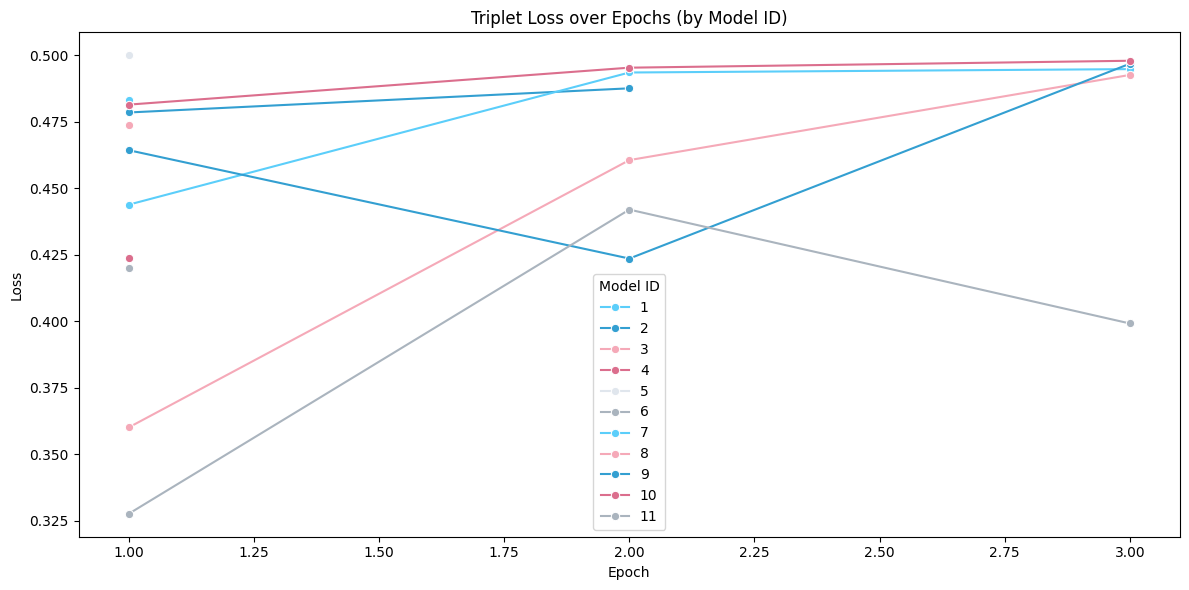

In [58]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_loss, x="epoch", y="loss", hue="model_id", marker="o", palette=trans_palette)
plt.title("Triplet Loss over Epochs (by Model ID)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title="Model ID", loc="best")
plt.tight_layout()
plt.show()

/var/folders/pf/k196hws969g1q7_pkdnv68ww0000gn/T/ipykernel_720/3779569306.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/pf/k196hws969g1q7_pkdnv68ww0000gn/T/ipykernel_720/3779569306.py:13: UserWarning: 
The palette list has fewer values (3) than needed (11) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


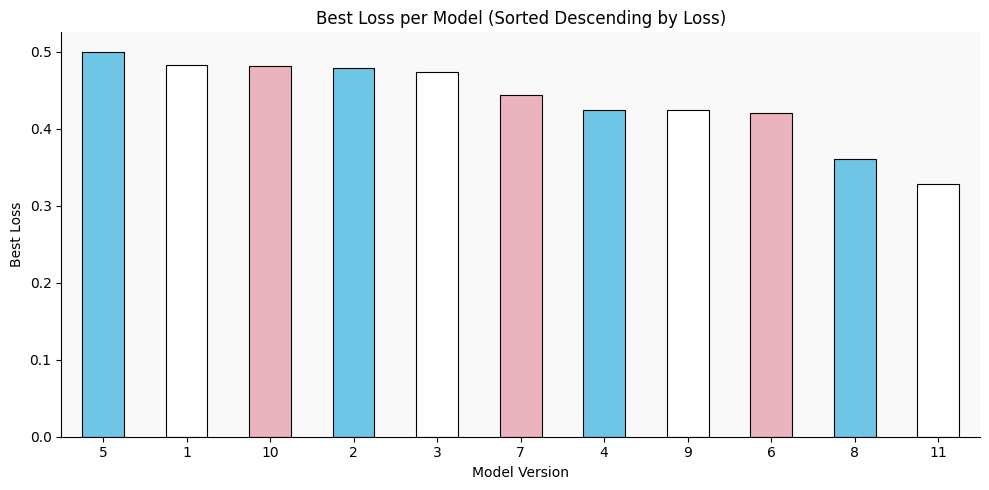

In [113]:
# Group and sort by best loss in descending order
best_loss_per_model = (
    df_loss.groupby("model_id")["loss"]
    .min()
    .reset_index()
    .sort_values(by="loss", ascending=False)
)

# Extract the order of model_ids for plotting
model_order = best_loss_per_model["model_id"]

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=best_loss_per_model,
    x="model_id",
    y="loss",
    palette=trans_palette,
    order=model_order,
    width=0.5,
    edgecolor="black",
    linewidth=0.8
)
ax.set_facecolor("#f9f9f9")  # 🧼 Off-white background for bar area only

plt.title("Best Loss per Model (Sorted Descending by Loss)")
plt.xlabel("Model Version")
plt.ylabel("Best Loss")
plt.xticks(rotation=0)
sns.despine()
plt.tight_layout()
plt.show()

/var/folders/pf/k196hws969g1q7_pkdnv68ww0000gn/T/ipykernel_720/776901975.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/pf/k196hws969g1q7_pkdnv68ww0000gn/T/ipykernel_720/776901975.py:13: UserWarning: 
The palette list has fewer values (3) than needed (11) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


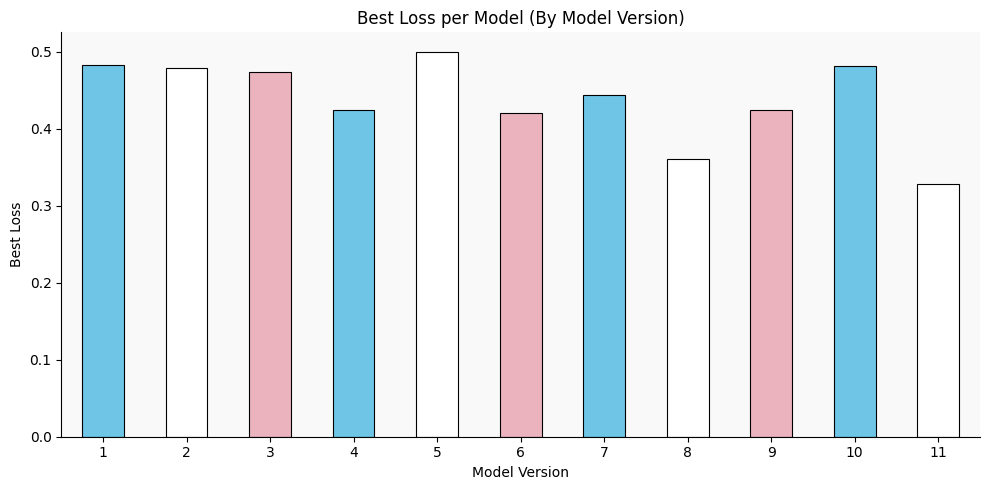

In [112]:
# Group by model_id and get the best loss (no sorting)
best_loss_per_model_chrono = (
    df_loss.groupby("model_id")["loss"]
    .min()
    .reset_index()
)

# Preserve chronological order (model_id = 1, 2, ..., 11)
model_order_chrono = best_loss_per_model_chrono["model_id"]

# Plot
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=best_loss_per_model_chrono,
    x="model_id",
    y="loss",
    palette=trans_palette,
    order=model_order_chrono,
    width=0.5,
    edgecolor="black",
    linewidth=0.8
)
ax.set_facecolor("#f9f9f9")  # 🧼 Off-white background for bar area only

plt.title("Best Loss per Model (By Model Version)")
plt.xlabel("Model Version")
plt.ylabel("Best Loss")
plt.xticks(rotation=0)
sns.despine()  # 🔥 Clean up plot borders
plt.tight_layout()
plt.show()

# HhhhhHHHHHHHHHHHHHHHH

confusion matrices

In [118]:
df_loss = pd.DataFrame(loss_records)
df_loss["model_id"] = df_loss["timestamp"].factorize()[0] + 1

get the three model joblib names for models 4, 8, 11

In [119]:
best_checkpoints = (
    df_loss.sort_values("loss")
    .groupby("model_id", as_index=False)
    .first()
)

# Get model_ids 4, 8, and 11
target_models = best_checkpoints[best_checkpoints["model_id"].isin([4, 8, 11])]
target_model_files = target_models["model_file"].tolist()
print(target_model_files)

['checkpoint_model_20250507101952_epoch1.joblib', 'checkpoint_model_20250511092238_epoch1.joblib', 'checkpoint_model_20250511133104_epoch1.joblib']


chat fuckin cooked here and she keeps trying to do other shit but this is as close as I got. ugh

In [ ]:
import os
import torch
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from dags.model_code import TripletNet  # from model.py
from torch.nn.functional import cosine_similarity

# -- Paths ---
MODEL_DIR = "/path/to/joblibs"  # 🔁 UPDATE this
CENTROIDS = {
    "pro": torch.load("centroids/pro.pt"),    # 🔁 UPDATE paths
    "anti": torch.load("centroids/anti.pt"),
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -- Load snapshot CSV with precomputed embeddings --
df = pd.read_csv("all_data_snapshot.csv")

# Convert embeddings into tensors
embedding_cols = [f"embedding[{i}]" for i in range(384)]  # adjust if dim is different
X = torch.tensor(df[embedding_cols].values, dtype=torch.float32).to(device)
y_true = df["stance"].map({"anti-trans": 0, "pro-trans": 1}).values  # or use stance_encoded if preferred

# -- Cosine classification function --
def classify(model, X):
    model.eval()
    with torch.no_grad():
        embedded = model.project(X)  # project() should map embedding → shared space
        pro_sim = cosine_similarity(embedded, CENTROIDS["pro"].unsqueeze(0))
        anti_sim = cosine_similarity(embedded, CENTROIDS["anti"].unsqueeze(0))
        preds = (pro_sim > anti_sim).long().squeeze()
    return preds.cpu().numpy()

# -- Confusion matrix plotter --
def plot_confusion(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Anti", "Pro"], yticklabels=["Anti", "Pro"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix — {model_name}")
    plt.tight_layout()
    plt.show()

# -- Evaluate selected models --
target_model_files = [
    "checkpoint_model_20250507101952_epoch1.joblib",
    "checkpoint_model_20250511092238_epoch1.joblib",
    "checkpoint_model_20250511133104_epoch1.joblib"
]

for fname in target_model_files:
    print(f"🔍 Evaluating {fname}...")
    model_path = os.path.join(MODEL_DIR, fname)
    model = TripletNet().to(device)
    model.load_state_dict(joblib.load(model_path))
    
    y_pred = classify(model, X)
    plot_confusion(y_true, y_pred, fname)